<a href="https://colab.research.google.com/github/greatermonk/Transformer-Architechture/blob/main/Transformers_Wine_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries
**1)tensorflow: >= 2.16**

**2)keras: >= 3.0**

**3)matplotlib: >= 3.9.0**

**4)numpy: >= 2.0**

In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import numpy as np
import json
import re
import string
from tensorflow.python import keras
from IPython.display import display, HTML
import tensorflow as tf
from keras import layers, models, losses, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.saving import register_keras_serializable

# Mount you google drive and load the wine-reviews dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/MyDrive/Transformers/winemag-data-130k-v2.json') as json_data:
     wine_reviews = json.load(json_data)

# Define HyperParameters for our model

**i) VOCAB_SIZE:**  The size of the vocabulary used by the model. It defines how many unique words or tokens the model can handle.

**ii) MAX_LEN:**  The maximum length of input sequences (in tokens).

**iii) EMBEDDING_DIM:**  The dimension of the word embeddings (vector representation of words).

**iv) K_DIM:**  The dimension of the keys used in the attention mechanism (specifically for multi-head attention in transformers).

**v) N_HEADS:**  The number of attention heads in the multi-head attention mechanism.

**vi) FF_DIM:**  The dimensionality of the feedforward layer in the transformer block.

**vii) VALIDATION_SPLIT:**  The fraction of the dataset that is used for validation.

**viii) SEED:**   A fixed random seed for reproducibility.

**ix) LOAD_MODEL:**   A flag indicating whether to load a pre-trained model or start training from scratch.

**x) BATCH_SIZE:**  The number of samples processed before the model's internal parameters are updated.

**xi) EPOCHS:**  The number of complete passes through the entire training dataset.



In [3]:
VOCAB_SIZE = 10000
MAX_LEN = 80
EMBEDDING_DIM = 256
K_DIM = 256
N_HEADS = 2
FF_DIM = 256
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 10

# Filter Dataset(preprocessing)

In [4]:
filtered_dataset = ["wine review : " + x["country"] + " : " + x["province"] + ":" + x["variety"] + " : " + x["description"] for x in wine_reviews if x["country"] is not None and x["province"] is not None and x["variety"] is not None and x["description"] is not None]

def pad_punctuation(s):
     s = re.sub(f"([{string.punctuation}, '\n'])", r" \1 ", s)
     s = re.sub(" +", " ", s)
     return s

text_data = [pad_punctuation(x) for x in filtered_dataset]

In [5]:
text_dataset = tf.data.Dataset.from_tensor_slices(text_data).batch(BATCH_SIZE).shuffle(129971)

**transforms text into tokenized sequences of integers, with each word represented by its corresponding index in the vocabulary**

In [6]:
vectorize_layer = layers.TextVectorization(standardize="lower", max_tokens=VOCAB_SIZE, output_mode="int", output_sequence_length=MAX_LEN + 1)
vectorize_layer.adapt(text_dataset)
vocab = vectorize_layer.get_vocabulary()   #Retrieves the list of words in the vocabulary.

In [7]:
def prepare_inputs(text):
     text = tf.expand_dims(text, -1)
     tokenized_sentence = vectorize_layer(text)
     x = tokenized_sentence[:, :-1]
     y = tokenized_sentence[:, 1:]
     return x, y

train_dataset = text_dataset.map(prepare_inputs)

# Define Attention Mask


In [8]:
def casual_attention_mask(batch_size, n_dest, n_src, dtype):
     i = tf.range(n_dest)[:, None]
     j = tf.range(n_src)
     m = i >= j - n_src + n_dest
     mask = tf.cast(m, dtype)
     mask = tf.reshape(mask, [1, n_dest, n_src])
     mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype = tf.int32)], 0)
     return tf.tile(mask, mult)

print(np.transpose(casual_attention_mask(1, 10, 10, tf.int32)[0]))   #Create an mask of 10 x 10

[[1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 1]]


# Define Transformer Block

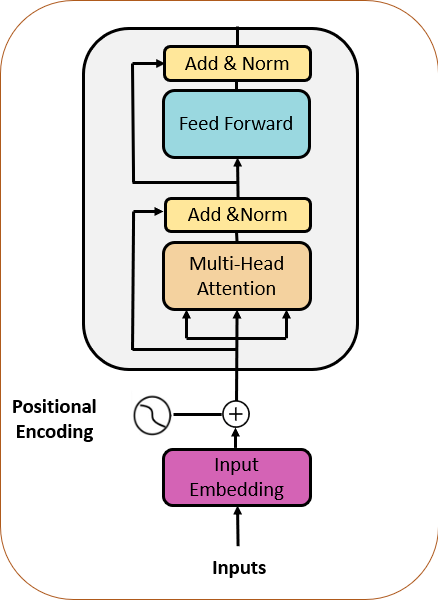

In [9]:
@register_keras_serializable()
class TransformerBlock(layers.Layer):
     def __init__(self, num_heads, key_dim, embed_dim, ff_dim, dropout_rate = 0.1):
          super(TransformerBlock, self).__init__()
          self.num_heads = num_heads
          self.key_dim = key_dim
          self.embed_dim = embed_dim
          self.ff_dim = ff_dim
          self.dropout_rate = dropout_rate
          self.attention = layers.MultiHeadAttention(num_heads, key_dim, output_shape = embed_dim)
          self.dropout_1 = layers.Dropout(self.dropout_rate)
          self.layerNormalizationLayer1 = layers.LayerNormalization(epsilon=1e-6)
          self.linearLayer1 = layers.Dense(self.ff_dim, activation="relu")
          self.linearLayer2 = layers.Dense(self.embed_dim)
          self.dropout_2 = layers.Dropout(self.dropout_rate)
          self.layerNormalizationLayer2 = layers.LayerNormalization(epsilon=1e-6)


     def call(self, inputs):
          input_shape = tf.shape(inputs)
          batch_size = input_shape[0]
          sequence_length = input_shape[1]
          casual_mask = casual_attention_mask(batch_size, sequence_length, sequence_length, tf.bool)
          attn_output, attn_scores = self.attention(inputs, inputs, attention_mask = casual_mask, return_attention_scores = True)
          attn_output = self.dropout_1(attn_output)
          out1 = self.layerNormalizationLayer1(inputs + attn_output)
          ffn_1 = self.linearLayer1(out1)
          ffn_2 = self.linearLayer2(ffn_1)
          ffn_output = self.dropout_2(ffn_2)
          return self.layerNormalizationLayer2(out1 + ffn_output), attn_scores


     def get_config(self):
          config = super().get_config()
          config.update(
               {
                    "key_dim": self.key_dim,
                    "embed_dim": self.embed_dim,
                    "num_heads": self.num_heads,
                    "ff_dim": self.ff_dim,
                    "dropout_rate": self.dropout_rate
               }
          )
          return config

# Tokens And Positional Embeddings

In [10]:
@register_keras_serializable()
class TokenAndPositionalEmbedding(layers.Layer):
     def __init__(self, max_len, vocab_size, embed_dim):
          super(TokenAndPositionalEmbedding, self).__init__()
          self.max_len = max_len
          self.vocab_size = vocab_size
          self.embed_dim = embed_dim
          self.token_embedding = layers.Embedding(input_dim = vocab_size, output_dim = embed_dim)
          self.positional_embedding = layers.Embedding(input_dim = max_len, output_dim = embed_dim)

     def call(self, x):
          max_length = tf.shape(x)[-1]
          positions = tf.range(0, max_length, 1)
          position_embeddings = self.positional_embedding(positions)
          token_embeddings = self.token_embedding(x)
          return token_embeddings + position_embeddings

     def get_config(self):
          config = super().get_config()
          config.update(
               {
                "max_length": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim
               }
          )
          return config

**Create an compile the model**

In [11]:
inputs = layers.Input(shape = (None, ), dtype = tf.int32)
x = TokenAndPositionalEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x, attention_scores = TransformerBlock(N_HEADS, K_DIM, EMBEDDING_DIM, FF_DIM)(x)
outputs = layers.Dense(VOCAB_SIZE, activation = "softmax")(x)
gpt_model = models.Model(inputs = inputs, outputs = [outputs, attention_scores])
gpt_model.compile("adam", loss = [losses.SparseCategoricalCrossentropy(), None], metrics = ["acc", "precision"])
gpt_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_positional_embedding       │ (None, None, 256)           │       2,580,480 │
│ (TokenAndPositionalEmbedding)        │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ [(None, None, 256), (None,  │         658,688 │
│                                      │ 2, None, None)]             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 10000)         │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,809,168 (22.16 MB)

 Trainable params: 5,809,168 (22.16 MB)

 Non-trainable params: 0 (0.00 B)

# TextGenerator

In [12]:
class TextGenerator(callbacks.Callback):
     def __init__(self, index_to_word):
          super(TextGenerator, self).__init__()
          self.index_to_word = index_to_word
          self.word_to_index = {word: index for index, word in enumerate(index_to_word)}
          self.word_probs = {}

     def sample_from(self, probs, temperature):
          probs =  probs ** (1 / temperature)
          probs = probs / np.sum(probs)
          return np.random.choice(len(probs), p = probs), probs

     def generate(self, start_prompt, max_tokens, temperature):
          start_tokens = [self.word_to_index.get(x, 1) for x in start_prompt.split()]
          sample_token = None
          info = []
          while len(start_tokens) < max_tokens and sample_token != 0:
               x = np.array([start_tokens])
               y, attn  = self.model.predict(x, verbose = 0)
               sample_token, probs = self.sample_from(y[0][-1], temperature)
               info.append(
                    {
                         "prompt": start_prompt,
                         "word_probabilities": probs,
                         "attention_scores": attn[0, :, -1, :]
                    }
               )
               start_tokens.append(sample_token)
               start_prompt = start_prompt + " " + self.index_to_word[sample_token]
          print(f"\nGenerated text:\n{start_prompt}\n")
          return info

     def on_epoch_end(self, epoch, logs=None):
          super().on_epoch_end(epoch, logs)
          self.generate("wine review", max_tokens = 50, temperature = 1.0)

**train and Save the model**

In [ ]:
model_checkpoint_callback = callbacks.ModelCheckpoint(filepath =  "/.weights.h5", save_weights_only=True, save_freq="epoch", verbose = 0)
tensorboard_callback = callbacks.TensorBoard(log_dir = "./logs")
text_generator = TextGenerator(vocab)
gpt_model.fit(train_dataset, epochs = EPOCHS, callbacks = [model_checkpoint_callback, tensorboard_callback, text_generator], batch_size=BATCH_SIZE)
#gpt_model.save('/content/drive/MyDrive/Transformers/gpt_model.keras')
#gpt_model.save_weights('/content/drive/MyDrive/Transformers/gpt_model_weights.weights.h5')

In [14]:
def display_probs_graph(info, vocab, top_k=10):
    for i in info:
        # Display highlighted text
        highlighted_text = []
        for word, attn_score in zip(i["prompt"].split(), np.mean(i["attention_scores"], axis=0)):
             highlighted_text.append(
                  f"<span style='background-color: rgba(155, 135, 12, {attn_score / max(np.mean(i['attention_scores'], axis=0))})'> \t {word}</span>"
             )
        highlighted_text = " ".join(highlighted_text)
        display(HTML(highlighted_text))
        # Get top k probabilities and their corresponding words
        word_probs = i["word_probabilities"]
        top_indices = np.argsort(word_probs)[::-1][:top_k]
        top_probs = word_probs[top_indices]
        top_words = [vocab[idx] for idx in top_indices]
        fig, ax = plt.subplots(figsize=(10, 5))
        plt.style.use("ggplot")
        y_pos = np.arange(len(top_words))
        ax.barh(y_pos, top_probs, align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_words)
        ax.invert_yaxis()  # Labels read top-to-bottom
        ax.set_xlabel('Probability')
        ax.set_title('Top {} tokens and their probabilities'.format(top_k))
        for j, v in enumerate(top_probs):
            ax.text(v, j, f' {v:.2%}', va='center')
        plt.tight_layout()
        plt.show()
        print("---------------------------------------------------------------------------------\n")

In [ ]:
info = text_generator.generate("wine_review: us", max_tokens = 50, temperature = 1.0)
#info2 = text_generator.generate("wine_review: italy", max_tokens = 30, temperature = 0.7)
#info3 = text_generator.generate("wine_review: germany", max_tokens = 30, temperature = 0.5)
display_probs_graph(info, vocab)
print("\n")
#print_probs(info2, vocab)
print("\n")
#print_probs(info3, vocab)